# Compare images

## Importar

In [1]:
# %load basic
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',200)
pd.options.display.float_format = '{:.2f}'.format
liga = '/Users/efraflores/Desktop/EF/corner/data/practice/'
os.listdir(liga)

['.DS_Store',
 'images.csv',
 'product_branches_heb_chedraui.xlsx',
 'images_array.csv',
 'product_branches_heb_chedraui.csv',
 'raceplot_data.txt',
 '2019-05.csv',
 'BASE DE VENTA NESTLE FEB 21.csv']

In [2]:
file = pd.read_csv(liga + 'images.csv')
file.sample(4)

,producto,name,_img_url
40,54,Detergente Matic en Polvo Naturals+Suavizante,https://superpal.s3.amazonaws.com/product-imag...
85,99,Fideos Spaghetti N° 5 Bolsa 400 g,https://superpal.s3.amazonaws.com/product-imag...
12,26,Abastero brasilero,https://superpal.s3.amazonaws.com/product-imag...
27,41,"Abuelo, Ron Botellón 5 años 1,75 L",https://superpal.s3.amazonaws.com/product-imag...


## Funciones

In [3]:
import time
import math

start = time.time()
def time_exp(x):
    print(str(int(math.floor(x/60))
             ) + " minutos con " + '{:.2f}'.format(60*(x/60 - math.floor(x/60))
                                                  ) + " segundos")

In [4]:
import numpy as np
from IPython.lib.display import Audio

def tono(a = 1000, b = 700, play_time_seconds = 1, framerate = 4410):
    t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)*np.pi
    return Audio(np.sin(a*t) + np.sin(b*t), rate = framerate, autoplay=True)

In [5]:
import requests
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

def img_to_df(file,image_col,id_col='producto',size=128):
    df = []
    productos = []
    for image,prod_id in zip(file[image_col],file[id_col]):
        try:
            requests.get(image, stream=True)
        except:
            pass
        else:
            raw_image = Image.open(requests.get(image, stream = True).raw)
            df.append(np.array(raw_image.resize((size,size))).ravel())
            productos.append(prod_id)
    df = pd.DataFrame(df).fillna(255)
    
    pca = PCA(.999)
    scale_after = MinMaxScaler()
    pipeline = Pipeline(steps=[('PCA', pca),
                               ('MinMax2', scale_after)])
    
    return pd.DataFrame(pipeline.fit_transform(df), index = productos)

In [6]:
def show_image_url(file,element,image_col='_img_url',id_col='producto',size=256):
    display(Image.open(requests.get(file.set_index(id_col).loc[element,image_col], 
                                    stream = True).raw).resize((size,size)))

In [15]:
from sklearn.neighbors import NearestNeighbors

def similar(df,n_vecinos=4,min_dist=.3):
    
    nbrs = NearestNeighbors(n_neighbors=n_vecinos, algorithm='ball_tree')
    nbrs.fit(df)
    distances, indices = nbrs.kneighbors(df)
    
    dist_cols = ['dist_'+str(x) for x in range(n_vecinos)]
    distances = pd.DataFrame(distances,
                             index=df.index,
                             columns=dist_cols).iloc[:,1:]
    distances = distances[distances['dist_1'] <= min_dist].copy()
    
    indices_cols = ['indice_'+str(x) for x in range(n_vecinos)]
    indices = pd.DataFrame(indices,
                           index=df.index,
                           columns=indices_cols).iloc[:,1:]
    
    indices.replace(dict(zip(range(len(indices)),df.index)),inplace = True)
    
    vecinos = distances.reset_index().merge(indices.reset_index(),
                                            on='index', 
                                            how = 'left').set_index('index')
    
    total_vecinos = []
    for row in vecinos.index:
        aux = []
        for dist_col,id_col in zip(dist_cols[1:],indices_cols[1:]):
            if vecinos.loc[row,dist_col] <= min_dist:
                aux.append(vecinos.loc[row,id_col])
        total_vecinos.append(aux)
    
    vecinos['vecinos'] = total_vecinos
    
    return vecinos

In [8]:
def comprobar(file,vecinos):
    for product_id,vecinos_col in zip(vecinos.index,vecinos['vecinos']):
        name = file.set_index('producto').loc[product_id,'name']
        print(f'La imagen del producto {product_id} con nombre {name},')
        show_image_url(file,product_id)
        print('Es parecida a el(los) siguiente(s) vecino(s):')
        for i,vecino in enumerate(vecinos_col):
            name_vecino = file.set_index('producto').loc[vecino,'name']
            print(f'{i+1}. Producto {vecino} con nombre {name_vecino}')
            show_image_url(file,vecino)
        print('-'*47,'\n')

## Transformar

In [9]:
df = img_to_df(file,'_img_url')
df.sample(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
66,0.31,0.81,0.17,0.35,0.23,0.44,0.75,0.36,0.17,0.40,0.56,0.07,0.73,0.55,0.70,0.30,0.50,0.21,0.26,1.00,0.64,0.01,0.57,0.89,0.58,0.45,0.51,0.59,0.86,0.32,0.91,0.12,0.37,0.42,0.41,0.39,0.26,0.40,0.31,0.63,0.90,0.60,0.62,0.56,0.30,0.55,0.18,0.42,0.47,0.35,0.44,0.46,0.37,0.44,0.55,0.38,0.38,0.41,0.44,0.39,0.39,0.49,0.45,0.28,0.53,0.43,0.45,0.41,0.42,0.33,0.50,0.45,0.48,0.41,0.45,0.45,0.50,0.34,0.39,0.41,0.49,0.47,0.49,0.44,0.35,0.48,0.43,0.39,0.47,0.42
89,0.10,0.36,0.13,0.66,0.66,0.43,0.49,0.28,0.48,0.27,0.38,0.28,0.30,0.51,0.67,0.26,0.44,0.36,0.41,0.50,0.48,0.35,0.25,0.66,0.54,0.31,0.42,0.38,0.53,0.45,0.40,0.37,0.46,0.39,0.28,0.55,0.49,0.64,0.37,0.47,0.42,0.57,0.43,0.36,0.53,0.32,0.37,0.48,0.54,0.87,0.33,0.42,0.18,0.51,0.29,0.24,0.13,0.63,0.56,0.34,0.06,0.57,0.19,0.13,0.16,0.34,0.30,0.08,0.50,1.00,0.63,0.36,1.00,0.44,0.87,0.62,0.41,0.33,0.49,0.38,0.40,0.54,0.49,0.35,0.36,0.54,0.43,0.40,0.50,0.45
26,0.17,0.65,0.06,0.49,0.47,0.28,0.47,0.50,0.07,0.64,0.30,0.48,0.15,0.36,0.37,0.44,0.72,0.49,0.44,0.34,0.49,0.44,0.64,0.50,0.53,0.34,0.64,0.53,0.49,0.48,0.52,0.30,0.50,0.35,0.54,0.39,0.54,0.68,0.31,0.38,0.59,0.48,0.16,0.41,0.09,0.50,0.39,0.24,0.46,0.77,0.56,0.54,0.15,0.11,0.62,0.11,0.28,1.00,1.00,0.48,0.77,0.57,0.58,0.31,0.44,0.58,0.50,0.50,0.39,0.36,0.33,0.31,0.61,0.39,0.52,0.37,0.56,0.39,0.42,0.33,0.44,0.51,0.46,0.46,0.35,0.43,0.46,0.42,0.47,0.43
102,0.12,0.32,0.14,0.59,0.62,0.39,0.41,0.30,0.34,0.26,0.37,0.18,0.47,0.60,0.63,0.24,0.45,0.38,0.48,0.51,0.55,0.38,0.31,0.54,0.51,0.45,0.61,0.32,0.41,0.49,0.41,0.53,0.40,0.51,0.45,0.44,0.56,0.55,0.33,0.35,0.54,0.50,0.46,0.46,0.43,0.36,0.36,0.13,0.51,0.56,0.27,0.44,0.27,0.39,0.23,0.20,0.34,0.22,0.58,0.06,0.56,1.00,0.17,0.44,0.78,0.78,0.47,0.02,0.82,0.11,0.38,0.94,0.37,0.30,0.37,0.23,0.76,0.45,0.34,0.44,0.42,0.42,0.36,0.48,0.34,0.55,0.40,0.38,0.51,0.43


In [16]:
vecinos = similar(df)
vecinos.head()

,dist_1,dist_2,dist_3,indice_1,indice_2,indice_3,vecinos
index,,,,,,,
19,0.84,1.19,1.38,38,105,111,[38]
34,0.77,1.16,1.38,38,35,105,[38]
38,0.77,0.84,0.90,34,19,105,"[34, 19, 105]"
105,0.90,1.04,1.15,38,92,111,[38]


## Validar

La imagen del producto 19 con nombre 24/7+, Contenedor de Vidrio Display 1 Un,


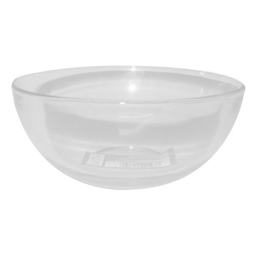

Es parecida a el(los) siguiente(s) vecino(s):
1. Producto 38 con nombre Vodka Vainilla Botella 750 cc


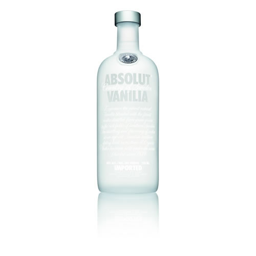

----------------------------------------------- 

La imagen del producto 34 con nombre Vodka Citron Botella 750 cc,


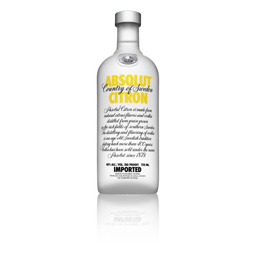

Es parecida a el(los) siguiente(s) vecino(s):
1. Producto 38 con nombre Vodka Vainilla Botella 750 cc


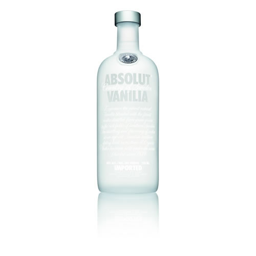

----------------------------------------------- 

La imagen del producto 38 con nombre Vodka Vainilla Botella 750 cc,


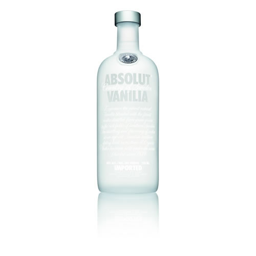

Es parecida a el(los) siguiente(s) vecino(s):
1. Producto 34 con nombre Vodka Citron Botella 750 cc


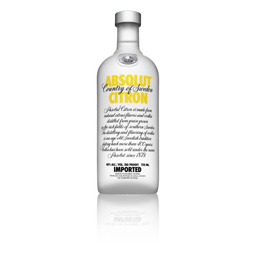

2. Producto 19 con nombre 24/7+, Contenedor de Vidrio Display 1 Un


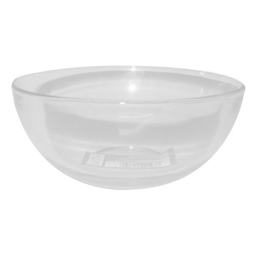

3. Producto 105 con nombre Jabón Líquido Cremoso Botella 2 L


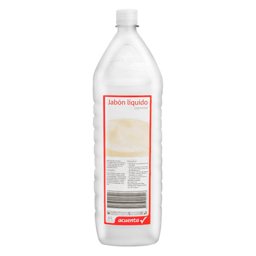

----------------------------------------------- 

La imagen del producto 105 con nombre Jabón Líquido Cremoso Botella 2 L,


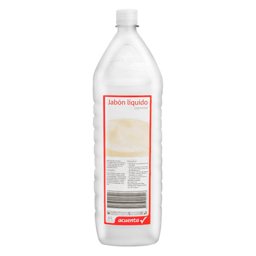

Es parecida a el(los) siguiente(s) vecino(s):
1. Producto 38 con nombre Vodka Vainilla Botella 750 cc


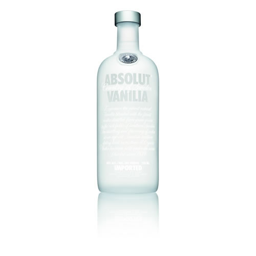

----------------------------------------------- 



In [17]:
comprobar(file,vecinos)

## Fin

In [12]:
time_exp(time.time() - start)
tono()

3 minutos con 16.82 segundos
